In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [9]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

magFORT=15.625
magRed=9.3
pgpixel=3.75
FORTconversion=pgpixel/magFORT
Redconversion=pgpixel/magRed
digit=1
def make_plots(QDP,retention):
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        if QDP.experiments[0]['variable_list']==[]:
            data=range(0,np.size(retention['ivar'],axis=1))
            xlab = 'iteration'
        else:
            xlab = QDP.experiments[0]['variable_desc'][QDP.experiments[0]['variable_list'][0]]['description']
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    plt.show()
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

    ### Beam positions plot, differential

    Xdata=np.squeeze(FORTconversion*QDP.get_beampositions()['FORTX']-Redconversion*QDP.get_beampositions()['RedX'])
    Ydata=np.squeeze(FORTconversion*QDP.get_beampositions()['FORTY']-Redconversion*QDP.get_beampositions()['RedY'])
    fig, ax = plt.subplots()
    #ax.scatter(Xdata-Xdata[0],Ydata-Ydata[0])
    ax.plot(data,Xdata-Xdata[0],'o',label='Delta X')
    ax.plot(data,Ydata-Ydata[0],'o',label='Delta Y')
    plt.show()
    #ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Drift @ atom plane(um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    
    ### Beam positions plot, Absolute
    
    Xdata_Red=Redconversion*np.squeeze(QDP.get_beampositions()['RedX'])
    Xdata_FORT=FORTconversion*np.squeeze(QDP.get_beampositions()['FORTX'])
    Ydata_Red=Redconversion*np.squeeze(QDP.get_beampositions()['RedY'])
    Ydata_FORT=FORTconversion*np.squeeze(QDP.get_beampositions()['FORTY'])
    ## X
    fig, ax = plt.subplots()
    ax.plot(data,Xdata_Red-np.round(np.nanmedian(Xdata_Red),digit),'o',label='Red X, offset:{}'.format(np.round(np.nanmedian(Xdata_Red),digit)))
    ax.plot(data,Xdata_FORT-np.round(np.nanmedian(Xdata_FORT),digit),'o',label='FORT X, offset:{}'.format(np.round(np.nanmedian(Xdata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    ## Y
    fig, ax = plt.subplots()
    ax.plot(data,Ydata_Red-np.round(np.nanmedian(Ydata_Red),digit),'o',label='Red Y, offset:{}'.format(np.round(np.nanmedian(Ydata_Red),digit)))
    ax.plot(data,Ydata_FORT-np.round(np.nanmedian(Ydata_FORT),digit),'o',label='FORT Y, offset:{}'.format(np.round(np.nanmedian(Ydata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

# middle of r1 and r2


In [10]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
exp_id='2018_02_23_10_14_04_Microwave Ramsey, 780A as stark shift beam, parked at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()

<IPython.core.display.Javascript object>


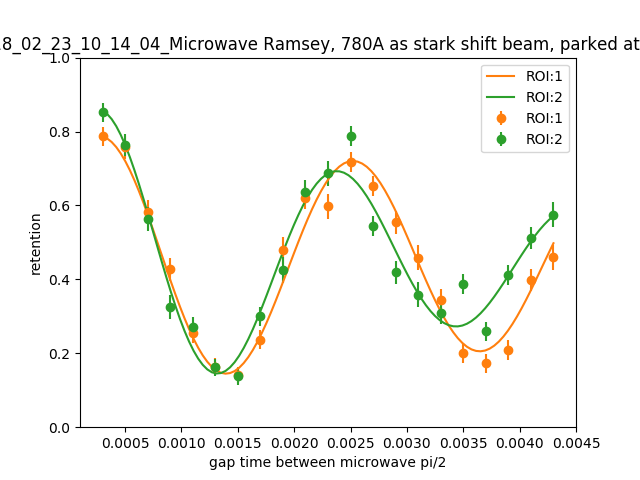

ROI:1, tau : 0.0101440879959, amplitude 0.348707901227 , freq:444.077029419, phase:0.785475515729, offset:0.448601086167
ROI:2, tau : 0.00399875508416, amplitude 0.432452531432 , freq:472.366041943, phase:0.713200150506, offset:0.45503977536


In [11]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.01,0.4,500,0,0.4]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    try:
        fit,pcov = curve_fit(decaying_sin,data,reten,guesses)
    except RuntimeError:
        error=1
    if error is not 1:
        print "ROI:{}, tau : {}, amplitude {} , freq:{}, phase:{}, offset:{}".format(roi,fit[0],fit[1],fit[2],fit[3],fit[4])
        fitted_parameters.append(fit[0])
        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0],fit[1],fit[2],fit[3],fit[4])
        plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

# Open loop, fixed gap time
2018_02_23_11_29_39_Open loop Microwave Ramsey, Fixed gap time, 780A as stark shift beam, parked at r1-r2

In [12]:
exp_id='2018_02_23_11_29_39_Open loop Microwave Ramsey, Fixed gap time, 780A as stark shift beam, parked at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()


[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


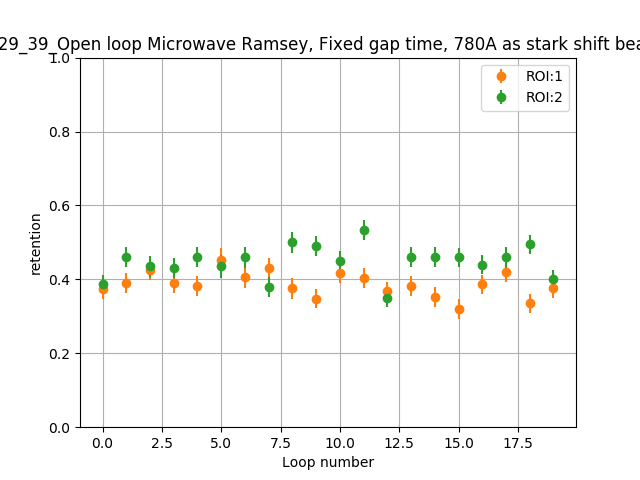

<IPython.core.display.Javascript object>


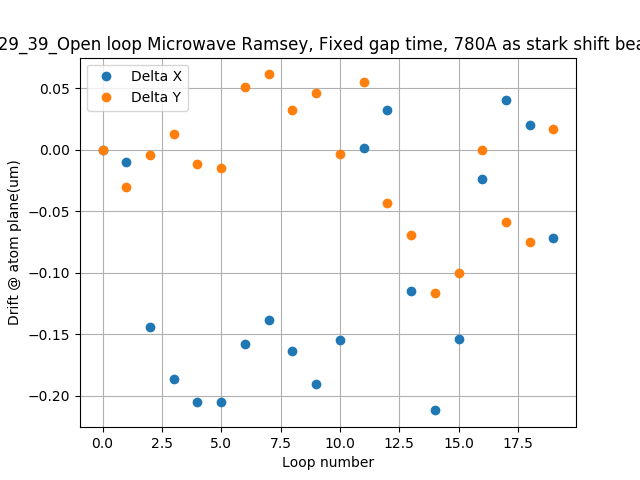

<IPython.core.display.Javascript object>


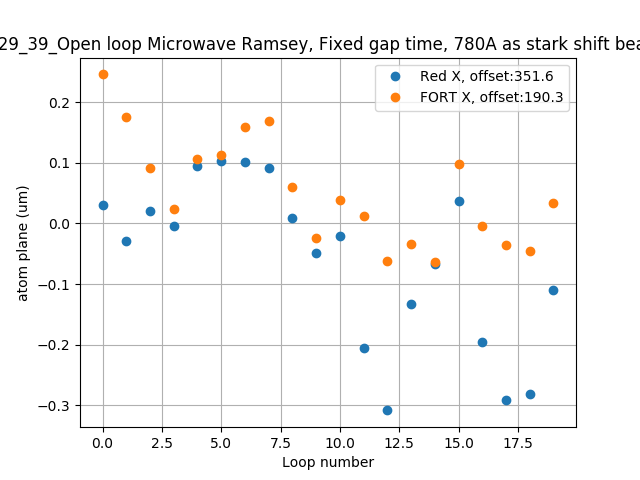

<IPython.core.display.Javascript object>


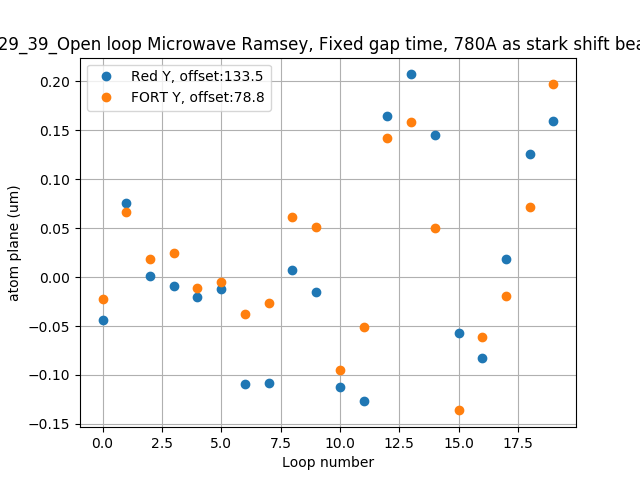

In [13]:
make_plots(q,retention)

# other experiments

[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


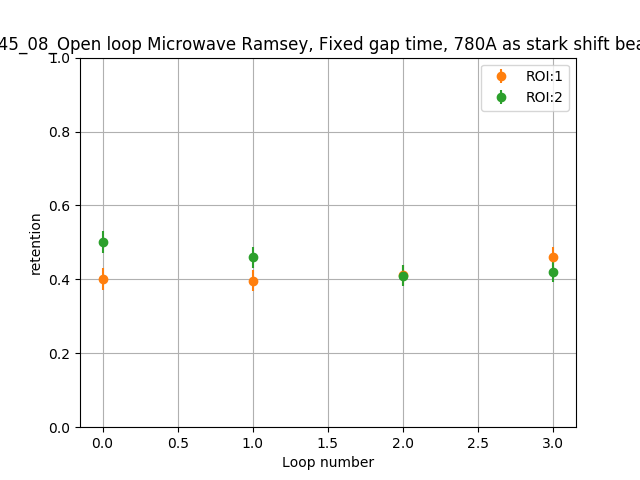

<IPython.core.display.Javascript object>


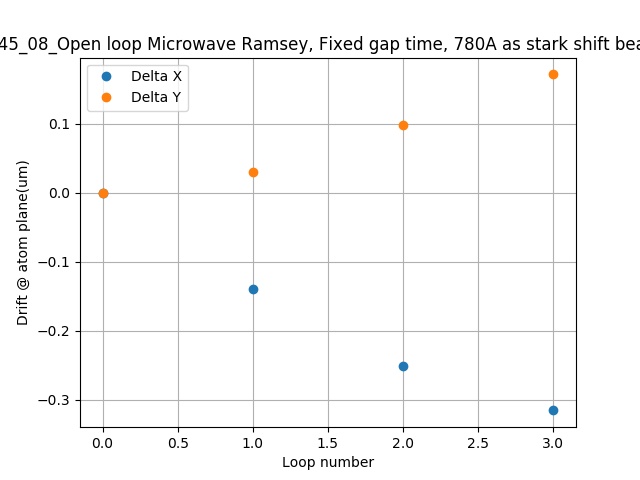

<IPython.core.display.Javascript object>


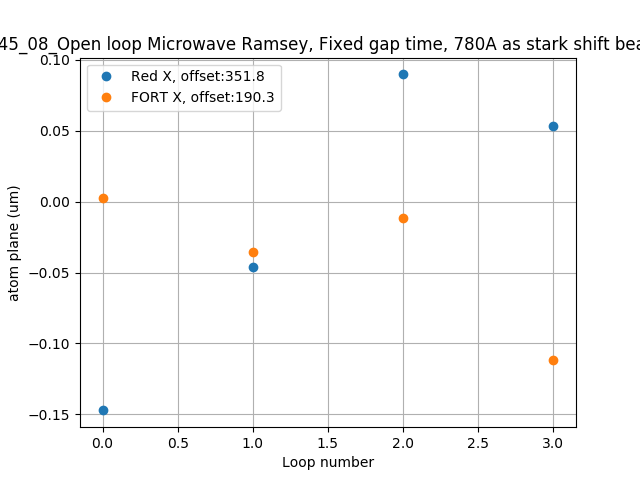

<IPython.core.display.Javascript object>


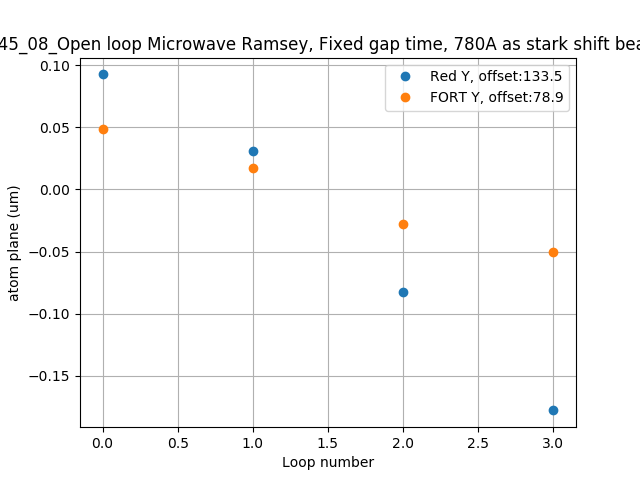

In [14]:
exp_id='2018_02_23_12_45_08_Open loop Microwave Ramsey, Fixed gap time, 780A as stark shift beam, parked at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()
make_plots(q,retention)

[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


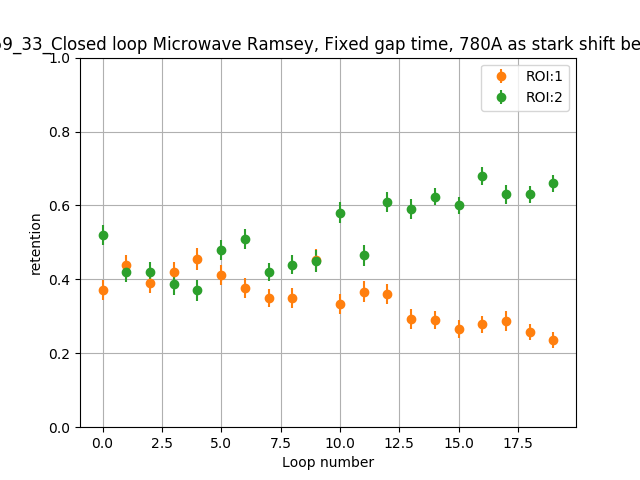

<IPython.core.display.Javascript object>


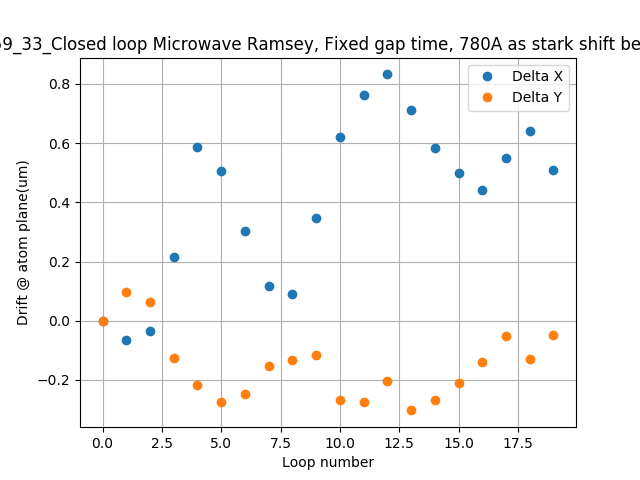

<IPython.core.display.Javascript object>


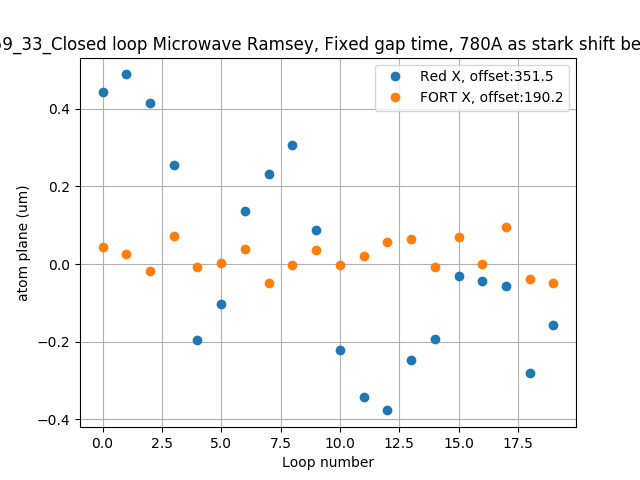

<IPython.core.display.Javascript object>


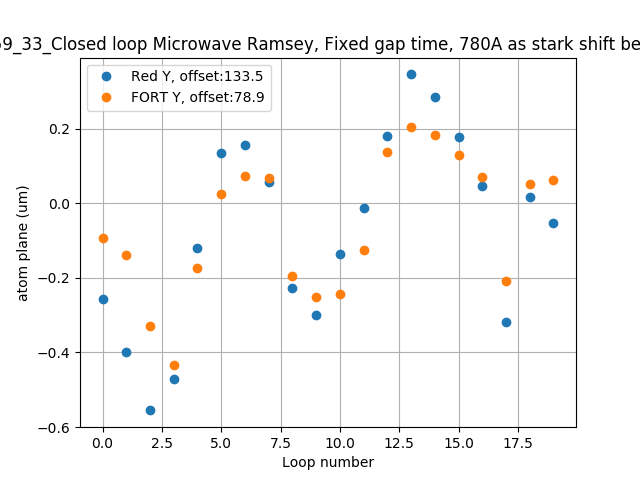

In [15]:
exp_id='2018_02_23_12_59_33_Closed loop Microwave Ramsey, Fixed gap time, 780A as stark shift beam, parked at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()
make_plots(q,retention)

[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


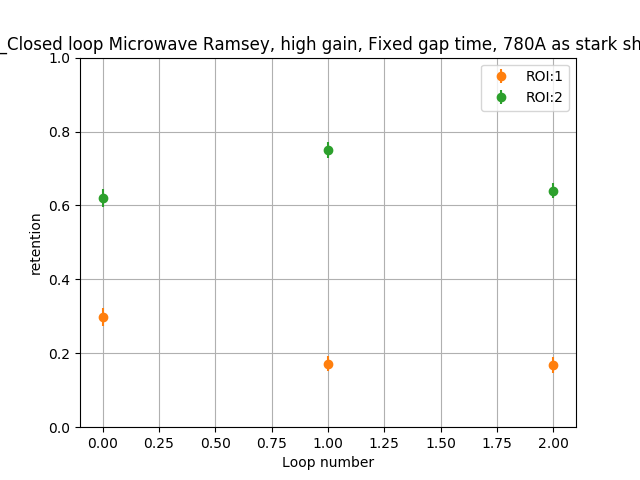

<IPython.core.display.Javascript object>


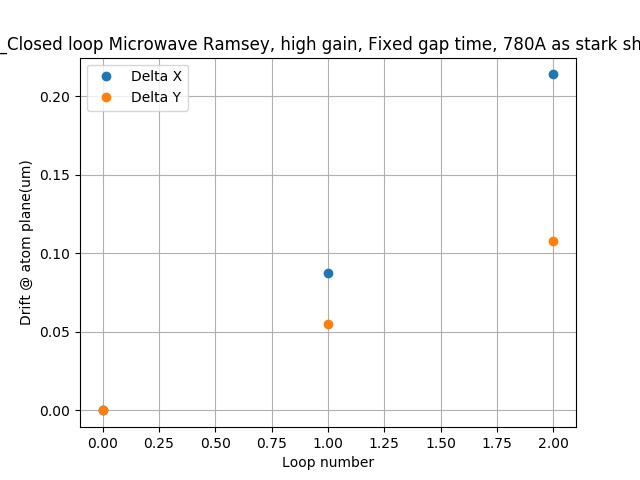

<IPython.core.display.Javascript object>


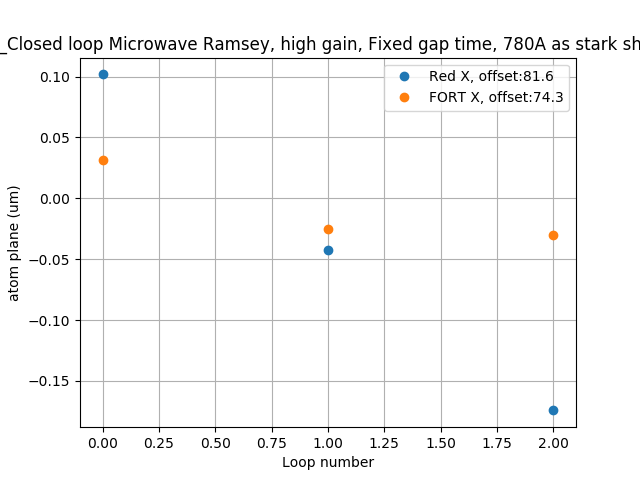

<IPython.core.display.Javascript object>


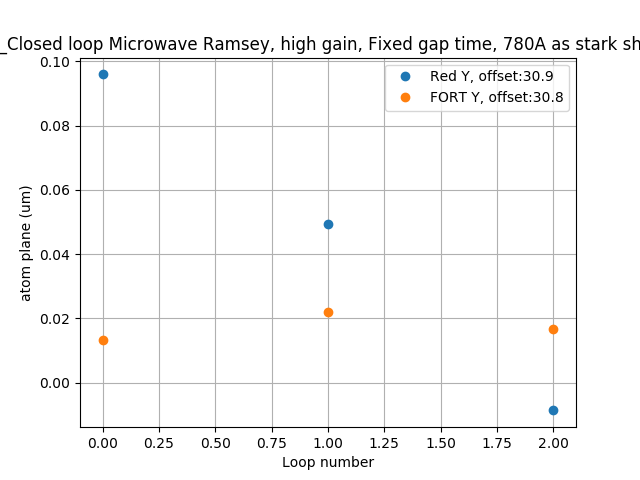

In [11]:
exp_id='2018_02_23_14_21_09_Closed loop Microwave Ramsey, high gain, Fixed gap time, 780A as stark shift beam, parked at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()
make_plots(q,retention)